#**Regression: European Call in Black & Scholes** 
We will show the limitations of linear regression when it comes to predicting the call price of a simple vanilla call option given the Black Scholes Formula.

Firstly we simulate the training set under the Black & Scholes Dynamics:

$$
\begin{array}{l}
{S_1} = X = {S_0}\exp \left( {\frac{{ - {\sigma_0^2 T_1}}}{2} + {\sigma}_0 \sqrt{T1} {N_1}} \right)\\
{S_2} = {S_1}\exp \left( {\frac{{ - {\sigma ^2 \left(T_2-T_1\right)}}}{2} + \sigma \sqrt{T_2-T_1} {N_2}} \right)\\
Y = \max \left( {0,{S_2} - K} \right)
\end{array}
$$

where $N_1$ and $N_2$ are independent standard Gaussians. (Note: we are simulating under a GBM from which BS is derived)

**<h3><center>Simulation of the training set</center></h3>**

In [0]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
simulations = 50000
T1 = 1.0
T2 = 2.0
K = 110.0

spot = 100.0
vol0 = 0.5
vol = 0.2

In [0]:
np.random.seed(42) #output will be the same for every run

# Simulate Gaussian return (N1, N2) as a matrix.
# shape: [simulations, Timestep=2]
returns = np.random.normal(size=[simulations, 2])

# Generate a vector with with scenarios for S1
# shape: [simulations, 1]
S1 = spot * np.exp(-0.5*vol0**2*T1 + vol0*np.sqrt(T1)*returns[:, 0])

# Generate a vector with scenarios for S2
# shape: [simulations, 1]
S2 = S1 * np.exp(-0.5*vol**2*(T2-T1) + vol*np.sqrt(T2-T1)*returns[:, 1])

# Create the training-set
#shape: [simulations, 1]
X = S1
Y = np.maximum(0, S2 - K)

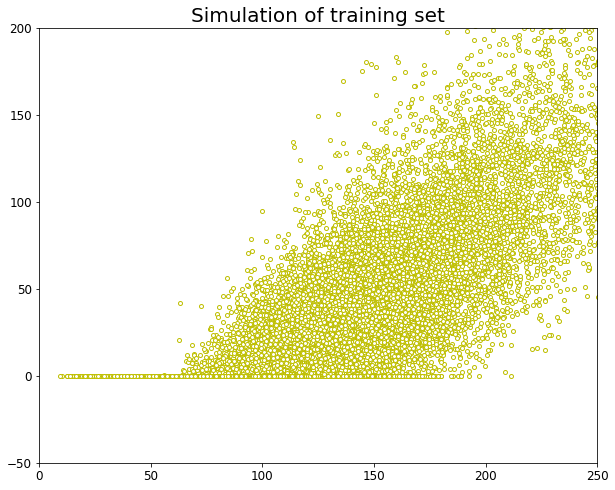

In [4]:
# Display the simulated data

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')
mpl.rcParams["animation.embed_limit"] = 50

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_title('Simulation of training set', fontsize=20,)
ax.set_xlim(0,250)
ax.set_ylim(-50,200)

ax.plot(X,Y, 'yo', markersize=4, markerfacecolor="white");

**<h3><center>Linear Regression</center></h3>**

Recall that the equation for simple linear regression is givena as:
$$
\begin{array}{l}
\hat y = E[y|x] = b+ \sum_{i=1}^{n} w_ix_i = b + w^Tx
\end{array}
$$
where b is the intercet and m is the slope of the line. So basically, the linear regression algorithm gives us the most optimal value for the intercept and the slope (in two dimensions). The y and x variables remain the same, since they are the data features and cannot be changed. The values that we can control are the intercept and slope. There can be multiple straight lines dependin upon the values of intercept and slope. Basically what the linear regression algorithm does is it fits multiple kunes on the data points and returns the line that results in the least error.

In [0]:
# import libraries
import pandas as pd 

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score

In [0]:
# Turn the vectors of shape [simulations] into a matrix of shape [simulations, 1]
X_LinReg = X.reshape(-1,1)
Y_LinReg = Y.reshape(-1,1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_LinReg, Y_LinReg, test_size=0.2, random_state=0)

In [0]:
# train algoritm using Linear Regression
regressor = LinearRegression()  
regressor.fit(X_train, y_train); #training the algorithm

In [8]:
"""
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)
# For every one unit change in S1, the change in Y is about 0.64%
"""

# Make some predictions
y_pred = regressor.predict(X_test)

"""
# Compare the actual output values for X_test with the predictive values
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df
"""

"\n# Compare the actual output values for X_test with the predictive values\ndf = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})\ndf\n"

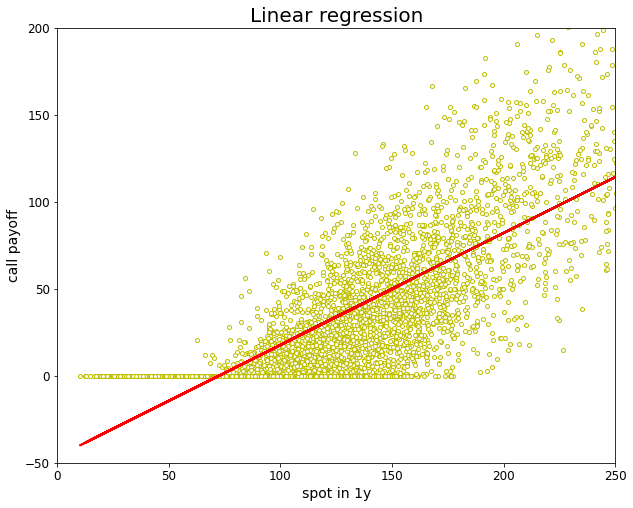

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_title('Linear regression', fontsize=20,)
ax.set_xlabel('spot in 1y')
ax.set_ylabel('call payoff')
ax.set_xlim(0,250)
ax.set_ylim(-50,200)

ax.plot(X_test,y_test, 'yo', markersize=4, markerfacecolor="white")
ax.plot(X_test, y_pred, color = 'red', linewidth = 2);

Linear regresion obviously fails to approximate the correct function because it cannot capture linearities.

**<h3><center>Polynomial Regression</center></h3>**

A solution to the above linear regression is to regress not on x, but on basis functions a of x.

An example of this could be to use polynomial regression. Polynomial regression is a form of linear regression in which the relationship between the independent variable x and the dependent variable y is mideled as an nth degree polynomial. Polynomial regression fits a nonlinear relationship between the value of x and the corresponding conditional mean of y, denoted E(y|x).

In [0]:
from sklearn.preprocessing import PolynomialFeatures

In [0]:
# simple wrapper class for multi-dimensional polynomial regression
class PolyReg:
    
    def __init__(self, X, Y, degree):
        
        # create monomials
        self.features = PolynomialFeatures(degree = degree)  
        self.monomials = self.features.fit_transform(X)
        
        # regress with normal equation
        self.model = LinearRegression()  
        self.model.fit(self.monomials, Y)

    def predict(self, x):
        
        # predict with dot product
        monomials = self.features.fit_transform(x)
        return self.model.predict(monomials)

# run regressions of degree = 1 to 6
polyRegs = [PolyReg(X.reshape(-1,1), Y, degree) for degree in range(1,7)]

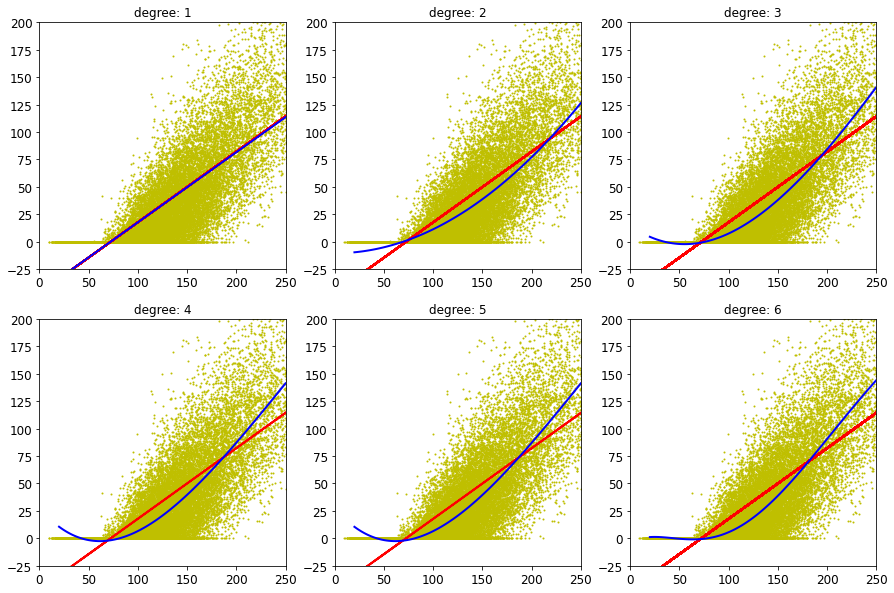

In [12]:
# compute and display results

# compute
# create 100 evenly distributed spot-prices from 20 to 250
xAxis = np.linspace(20, 250, 100)
poly = [polyReg.predict(xAxis.reshape(-1,1)) for polyReg in polyRegs]

# display
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(15, 10)
for i in [0,1]:
    for j in [0,1,2]:
        polIdx = 3*i + j
        ax[i, j].set_xlim(0,250)
        ax[i, j].set_ylim(-25,200)
        ax[i,j].set_title("degree: " + str(1 + polIdx))
        ax[i,j].plot(X,Y, 'yo', markersize=1)
        ax[i,j].plot(X_test, y_pred, color = 'red', linewidth = 2)
        ax[i,j].plot(xAxis, poly[polIdx], 'blue', linewidth = 2)

In [0]:
def create_linear_regression_model():
  "Creates a linear regression model"

  #fit to linear regression
  regressor = LinearRegression()  
  regressor.fit(X_train, y_train)

  #predict on train data set
  y_pred = regressor.predict(X_train)

  # predict on test data set
  y_predt = regressor.predict(X_test) 

  # evaluating the model on training dataset
  mae_train_lr = metrics.mean_absolute_error(y_train, y_pred)
  mse_train_lr = metrics.mean_squared_error(y_train, y_pred)
  rmse_train_lr = np.sqrt(metrics.mean_squared_error(y_train, y_pred))
  r2_train_lr = r2_score(y_train, y_pred)

  # evaluating the model on test dataset
  mae_test_lr = metrics.mean_absolute_error(y_test, y_predt)
  mse_test_lr = metrics.mean_squared_error(y_test, y_predt)
  rmse_test_lr = np.sqrt(metrics.mean_squared_error(y_test, y_predt))
  r2_test_lr = r2_score(y_test, y_predt)

  print("LINEAR REGRESSION:")
  print("The model performance for the training set:")
  print("-------------------------------------------")
  print("MAE of training set is {}".format(mae_train_lr))
  print("MSE of training set is {}".format(mse_train_lr))
  print("RMSE of training set is {}".format(rmse_train_lr))
  print("R2 score of training set is {}".format(r2_train_lr))
  
  print("\n")
  
  print("The model performance for the test set:")
  print("-------------------------------------------")
  print("MAE of training set is {}".format(mae_test_lr))
  print("MSE of training set is {}".format(mse_test_lr))
  print("RMSE of test set is {}".format(rmse_test_lr))
  print("R2 score of test set is {}".format(r2_test_lr))


def create_polynomial_regression_model(degree):
  
  "Creates a polynomial regression model for the given degree"
  
  poly_features = PolynomialFeatures(degree=degree)
  
  # transforms the existing features to higher degree features.
  X_train_poly = poly_features.fit_transform(X_train)
  
  # fit the transformed features to Linear Regression
  poly_model = LinearRegression()
  poly_model.fit(X_train_poly, y_train)
  
  # predicting on training data-set
  y_train_predicted = poly_model.predict(X_train_poly)
  
  # predicting on test data-set
  y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
  
  # evaluating the model on training dataset
  mae_train = metrics.mean_absolute_error(y_train, y_train_predicted)
  mse_train = metrics.mean_squared_error(y_train, y_train_predicted)
  rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_train_predicted))
  r2_train = r2_score(y_train, y_train_predicted)
  
  # evaluating the model on test dataset
  mae_test = metrics.mean_absolute_error(y_test, y_test_predict)
  mse_test = metrics.mean_squared_error(y_test, y_test_predict)
  rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_test_predict))
  r2_test = r2_score(y_test, y_test_predict)
  
  print("POLYNOMIAL REGRESSION:")
  print("The model performance for the training set with degree: " + str(degree))
  print("-------------------------------------------")
  print("MAE of training set is {}".format(mae_train))
  print("MSE of training set is {}".format(mse_train))
  print("RMSE of training set is {}".format(rmse_train))
  print("R2 score of training set is {}".format(r2_train))
  
  print("\n")
  
  print("The model performance for the test set with degree: " + str(degree))
  print("-------------------------------------------")
  print("MAE of training set is {}".format(mae_test))
  print("MSE of training set is {}".format(mse_test))
  print("RMSE of test set is {}".format(rmse_test))
  print("R2 score of test set is {}".format(r2_test))

  print("\n")

In [14]:
create_linear_regression_model()

LINEAR REGRESSION:
The model performance for the training set:
-------------------------------------------
MAE of training set is 16.739750625797146
MSE of training set is 581.302523259255
RMSE of training set is 24.110216159529866
R2 score of training set is 0.6732180375957559


The model performance for the test set:
-------------------------------------------
MAE of training set is 16.606142762112366
MSE of training set is 537.5679694442351
RMSE of test set is 23.18551205913372
R2 score of test set is 0.6685262402456396


In [0]:
Degrees = 6

for i in range(1,Degrees + 1):
  create_polynomial_regression_model(i)

**<h3><center>The Black and Scholes Formula</center></h3>**

To access how well our above polynomial regression works in terms of accuracy, we implement the black and scholes formula. In this way we can compare the model predictions with the correct results:

$$
B{S_{K,T,\sigma }}\left( S \right) = SN\left( {\frac{{\log \left( {\frac{S}{K}} \right) + \frac{{{\sigma ^2 T}}}{2}}}{\sigma \sqrt{T} }} \right) - KN\left( {\frac{{\log \left( {\frac{S}{K}} \right) - \frac{{{\sigma ^2 T}}}{2}}}{\sigma\sqrt{T} }} \right)
$$

In [0]:
from scipy.stats import norm # cumulative normal distribution

# Recall that we in the above example had a fixed strike vol and expiry:
def Blackscholes_call(S, K, vol, T):
  d1 = (np.log(S / K) + 0.5 * vol**2 * T) / vol * np.sqrt(T)
  d2 = (np.log(S / K) - 0.5 * vol**2 * T) / vol * np.sqrt(T)

  return S * norm.cdf(d1) - K * norm.cdf(d2)

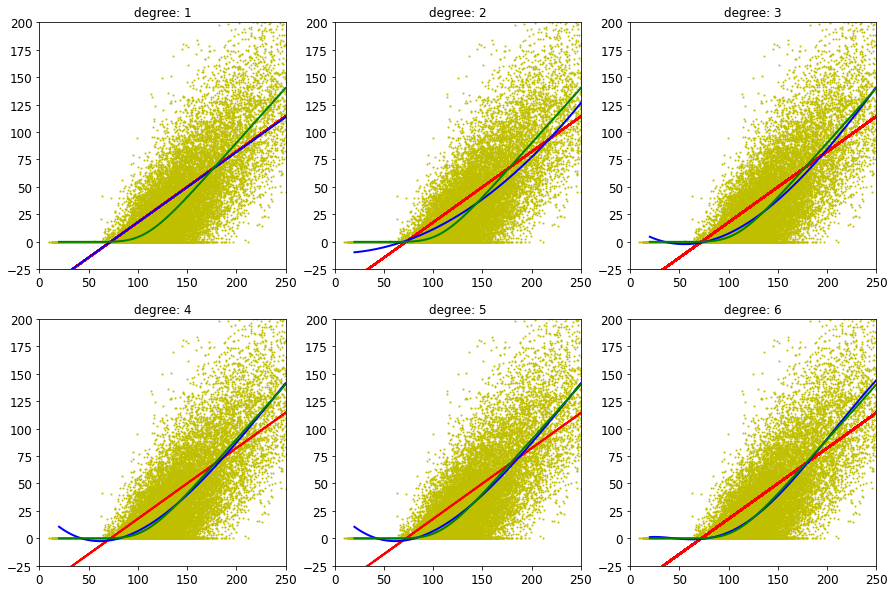

In [30]:
target = Blackscholes_call(S = xAxis, K = 110, vol = vol, T = T2 - T1)

# display
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(15, 10)
for i in [0,1]:
    for j in [0,1,2]:
        polIdx = 3*i + j
        ax[i, j].set_xlim(0,250)
        ax[i, j].set_ylim(-25,200)
        ax[i,j].set_title("degree: " + str(1 + polIdx))
        ax[i,j].plot(X,Y, 'yo', markersize=1)
        ax[i,j].plot(X_test, y_pred, color = 'red', linewidth = 2)
        ax[i,j].plot(xAxis, poly[polIdx], 'blue', linewidth = 2)
        ax[i,j].plot(xAxis, target, 'green', linewidth = 2)